# Violation of Baccari et al.'s Bell inequality for path graphs from size 2 to 57 on IBM Quantum Brooklyn

In [1]:
import sys
import time
import numpy as np
import pickle

In [2]:
min_size = 40
max_size = 105

In [4]:
with open("./pkls/raw_hist_list.pkl", "rb") as f:
    raw_hist_list = pickle.load(f)
with open("./pkls/lnp_hist_list.pkl", "rb") as f:
    lnp_hist_list = pickle.load(f)

In [5]:
sys.path.append("../../libs_bell/")
from lib_graph_states import adjacency_list_for_path_graph, list_to_matrix
F_list = [3 * i + 1 for i in range(max_size // 3)] # subset of focused vertices of graph size max_size
Fs = [F_list[:(n+1) // 3] for n in range(min_size, max_size + 1)] # subsets of focused vertices of graph size 1 to max_size
adj_lists = [adjacency_list_for_path_graph(n) for n in range(min_size, max_size + 1)] # adjacency list of graph size 1 to max_size
graphs = [list_to_matrix(adj_list) for adj_list in adj_lists] # adjacency matrix of graph size 1 to max_size
print("max_size:", max_size)
print("F_list:", F_list)

max_size: 105
F_list: [1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55, 58, 61, 64, 67, 70, 73, 76, 79, 82, 85, 88, 91, 94, 97, 100, 103]


In [6]:
from lib_path_graphs import * # correlations_of_path_graphs

In [7]:
def correlations_of_path_graphs(adj_lists, Fs, hist_list, silent = True):
    """
    Input
        adj_lists         : list of adjacency list
        Fs                : list of vertex subset
        hist_list  : list of int list (list of hist)
    Output
        expval_all_list : list of float (correlation of each graph)
        stddev_all_list : list of float (standard deviation of each graph)
        Es_all_list     : list of list (term-wise correlation of each graph)
        Ds_all_list     : list of list (term-wise stddev of each graph)
    """
    corr_all_list, stddev_all_list, Es_all_list, Ds_all_list = [], [], [], []

    assert len(hist_list) % 2 == 0

    for i in range(len(adj_lists)):
        adj_list = adj_lists[i]
        F = Fs[i]
        n = len(adj_list)
        print("graph size:", n)
        if n <= 1:
            print("skipped\n")
            corr_all_list.append(0)
            stddev_all_list.append(0)
            Es_all_list.append([])
            Ds_all_list.append([])
            continue

        # XZXZXZXZ
        hist_xz = hist_list[2 * i] # fixed
        # ZXZXZXZX
        hist_zx = hist_list[2 * i + 1] # fixed

        Es_F, Ds_F, corr_F = [], [], 0
        remaining = remaining_vertices(adj_list, n, F)

        for m in F:
            hist, poses = extract_sub_hist(hist_xz, hist_zx, m, n)
            corr_itself, stddev_itself = mit.expectation_value(
                hist, qubits=poses, clbits=poses, meas_mitigator=None)
            corr_deg = corr_itself * len(adj_list[m])
            Es_m, Ds_m = [corr_itself], [stddev_itself * len(adj_list[m])]
            for j, _ in enumerate(adj_list[m]):
                hist, poses = extract_sub_hist(hist_xz, hist_zx, j, n)
                expval, stddev = mit.expectation_value(hist, qubits=poses, clbits=poses, meas_mitigator=None)
                Es_m.append(expval)
                Ds_m.append(stddev)
            sum_corr = corr_deg + sum(Es_m[1:])
            if not silent:
                print("correlation on n[", m, "]:", sum_corr)
            corr_F += sum_corr
            Es_F.append(Es_m)
            Ds_F.append(Ds_m)

        # remainig part
        Es_R, Ds_R = [], []
        for i, _ in enumerate(remaining):
            hist, poses = extract_sub_hist(hist_xz, hist_zx, i, n)
            expval, stddev = mit.expectation_value(hist, qubits=poses, clbits=poses, meas_mitigator=None)
            Es_R.append(expval)
            Ds_R.append(stddev)
        corr_R = sum(Es_R)
        if not silent:
            print("correlation on remaining vertices:", corr_R)

        corr_F *= np.sqrt(2)
        corr_all = corr_F + corr_R
        corr_all_list.append(corr_all)
        stddev_all_list.append(np.sqrt(2 * sum([dev ** 2 for Ds_m in Ds_F for dev in Ds_m]) + sum([dev ** 2 for dev in Ds_R])))
        Es_all_list.append([Es_F, Es_R])
        Ds_all_list.append([Ds_F, Ds_R])
        print("total correlation:", corr_all, "\n")
    return corr_all_list, stddev_all_list, Es_all_list, Ds_all_list

In [8]:
corr_list, stddev_list, Es_list, Ds_list = correlations_of_path_graphs(adj_lists, Fs, raw_hist_list)

graph size: 40
total correlation: 61.44919718114826 

graph size: 41
total correlation: 62.32414310155454 

graph size: 42
total correlation: 63.854366370216056 

graph size: 43
total correlation: 64.73477216504607 

graph size: 44
total correlation: 66.24844763034667 

graph size: 45
total correlation: 67.71479650715297 

graph size: 46
total correlation: 68.66682574544225 

graph size: 47
total correlation: 70.80562653898009 

graph size: 48
total correlation: 73.14757248467754 

graph size: 49
total correlation: 73.58199744070998 

graph size: 50
total correlation: 75.39111734021962 

graph size: 51
total correlation: 78.03206449319613 

graph size: 52
total correlation: 78.98562500051341 

graph size: 53
total correlation: 80.25972706752016 

graph size: 54
total correlation: 82.96903708313093 

graph size: 55
total correlation: 83.90637301912918 

graph size: 56
total correlation: 85.36173727532955 

graph size: 57
total correlation: 88.20259401146377 

graph size: 58
total correl

In [19]:
lnp_corr_list, lnp_stddev_list, lnp_Es_list, lnp_Ds_list = correlations_of_path_graphs(adj_lists[60:], Fs, lnp_hist_list)

graph size: 100
total correlation: 99.57303378847294 

graph size: 101
total correlation: 105.89947519490045 

graph size: 102
total correlation: 107.02837477590808 

graph size: 103
total correlation: 111.78675435865898 

graph size: 104
total correlation: 116.18868129160472 

graph size: 105
total correlation: 111.48088729327324 



## plot correlations

In [13]:
c_bounds = [n + (n // 3) for n in range(min_size, max_size + 1)]
q_bounds = []
for n in range(min_size, max_size + 1):
    q_bounds.append( 2 * (np.sqrt(2) * 2 - 1) * (n // 3) + n - ((n + 1) // 3))
    if (n + 1) % 3 == 0:
        q_bounds[-1] += (np.sqrt(2) * 2 - 1)

In [14]:
from lib_plots import *

In [23]:
def plot_correlations_lines(min_size,
                            max_size,
                            c_bounds,
                            q_bounds,
                            corrs_list,
                            stddevs_list,
                            labels,
                            title):
    plt.clf()
    plt.figure(dpi=200)
    plt.style.use('ggplot')
    plt.plot(list(range(min_size, max_size + 1)),
             c_bounds[:max_size], label="Classical bounds")
    plt.plot(list(range(min_size, max_size + 1)),
             q_bounds[:max_size], label="Quantum bounds")
    for i in range(len(corrs_list)):
        print(corrs_list[i], stddevs_list[i])
        plt.fill_between(list(range(min_size, max_size + 1)), corrs_list[i] - stddevs_list[i], corrs_list[i] + stddevs_list[i], alpha=0.2)
        plt.plot(list(range(min_size, max_size + 1)), corrs_list[i], label = labels[i])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.xlabel("graph size")
    plt.ylabel("correlation value")
    plt.xticks(list(range(min_size - 1, max_size + 2))[::4])
    plt.title(title)
    plt.show()

In [24]:
lnp_corr_list

[99.57303378847294,
 105.89947519490045,
 107.02837477590808,
 111.78675435865898,
 116.18868129160472,
 111.48088729327324]

In [25]:
lnp_stddev_list

[0.10103879188748281,
 0.1025429037966457,
 0.10136506531557962,
 0.09339237415767147,
 0.0927110348867001,
 0.1036420908998331]

In [29]:
corr_list = np.array(corr_list)
stddev_list = np.array(stddev_list)
lnp_corr_list = np.array(lnp_corr_list)
lnp_stddev_list = np.array(lnp_stddev_list)

<Figure size 432x288 with 0 Axes>

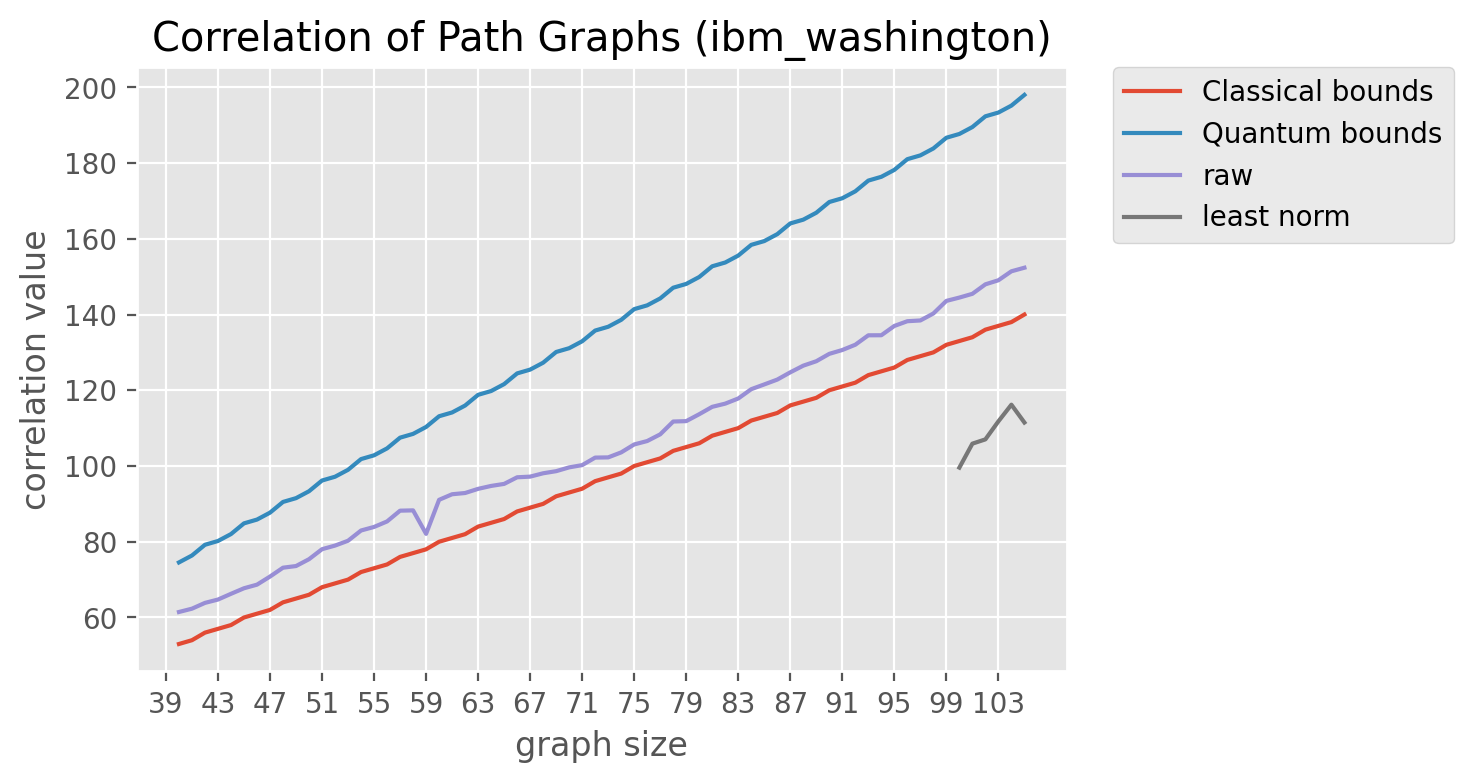

In [31]:
plt.clf()
plt.figure(dpi=200)
plt.style.use('ggplot')
plt.plot(list(range(min_size, max_size + 1)),c_bounds[:max_size], label="Classical bounds")
plt.plot(list(range(min_size, max_size + 1)),q_bounds[:max_size], label="Quantum bounds")

plt.fill_between(list(range(min_size, max_size + 1)), corr_list - stddev_list, corr_list + stddev_list, alpha=0.2)
plt.plot(list(range(min_size, max_size + 1)), corr_list, label = "raw")

plt.fill_between(list(range(min_size + 60, max_size + 1)), lnp_corr_list - lnp_stddev_list, lnp_corr_list + lnp_stddev_list, alpha=0.2)
plt.plot(list(range(min_size + 60, max_size + 1)), lnp_corr_list, label = "least norm")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel("graph size")
plt.ylabel("correlation value")
plt.xticks(list(range(min_size - 1, max_size + 2))[::4])
plt.title("Correlation of Path Graphs (ibm_washington)")
plt.show()

100qubitを超えるもので、誤差緩和なしで、
Bell不等式の破れを確認でき、よろしいですね。
（理論的には、誤りがあるのを勘案しないといけませんが、
その前段階で。）

これでは、たとえばGoogleのrepetition code

https://ai.googleblog.com/2021/08/demonstrating-fundamentals-of-quantum.html
を試す、というのは厳しそうでしょうか？

ところで、送ってもらった実験結果で、

Q. 
59点のパスのところで、一度測定結果がへこんでます？
こちら、グラフで58点のパスからどの点を伸ばしたところでしょうか？
その点へ伸ばした枝のCNOT性能が悪いとかありますか？


A. 
はい、その通りです。
CNOTの性能が悪い

あるいは

・Baccariらのグラフ状態の不等式で、最大次数3の点をどこかに固定してて、
その点の周囲だけちょっと独自になっている点の影響でしょうか？

あと、理論としては、

・生成したグラフ状態が、正確なグラフ状態からずれているのを、
　実験的になり
　理論的になり
Bell不等式との関係で調べたりできますか？

田村さんは前の打合せで、3重の符号（正確なtechnical termではないですが）を使ってと思います。そういう関係のを何かグラフで関係することを考えられるかなども。

・以前のコード、今一度washintonにかけてみては。それでもおかしいのなら、バグの可能性もまだあるような。

・Error Mitigationはできるのですか、このサイズで？

・量子グラフ状態が正確には生成できてない件ですが、Qiskitのerror modelを使ってのsimulatorでの計算は大規模過ぎて無理でしょうか。

・だとすると、安易ですが、量子グラフ状態にdecohence errorなになにか適当なエラーが入ったものを考えて、測定は正確にできるという仮定で、BaccariらのBellの不等式の破れの意味を考察できたりしませんか？

